# Imports needed for DQN
## Custom Reward Model

In [4]:
"""
Import Statements: From PyTorch RL Tutorial
Unchanged code from Milestone
"""
import gym
import math
import random
import numpy as np
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import nle
from collections import namedtuple, deque

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Internal Imports & Setup

In [5]:
from utils.terminal_stream import TerminalStream
from utils.nle_metrics import NetHackMetricsEnv

# Replay Memory Class
## Used to store a state into a queue (used in policy calculation)

In [6]:
StateTransition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

In [7]:
"""
This model stores replays of memories as a whole. It also holds the full set, and manages removing old memories.
From PyTorch DQN Tutorial
"""
class ReplayMemory():
    def __init__(self, max_memory):
        self.memory = deque([], maxlen=max_memory)
    
    def push(self, *newExp):
        self.memory.append(StateTransition(*newExp))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

# DQN Model, with two Conv2d layers
## Takes the input provided by the dictionary in state

In [8]:
"""
DQN implementation, with convolutional layers, max pooling implemented.
"""
class DQNetwork(nn.Module):
    def __init__(self, n_actions):
        super(DQNetwork, self).__init__()
        self.joe = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=3, padding='same'),
            nn.ReLU(), # 21 * 79 * 16
            nn.MaxPool2d(3, padding=(0,1)), # 7 * 27 * 16
            nn.Conv2d(16, 64, kernel_size=3, padding='same'),# 7 * 27 * 64
            nn.ReLU(),
            nn.MaxPool2d(3, padding=(1,0)), # 3 * 9 * 64
            nn.Flatten(),
            nn.Linear(3*9*64, 3*64),
            nn.ReLU(),
            # Hard coded activation layer
            nn.Linear(3*64, n_actions),
        )
        
    def forward(self, x):
        logits = self.joe(x.float())
        return logits

# Training

In [9]:
env = NetHackMetricsEnv('Testing-nle-metric')

In [10]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
steps_done = 0
episode_durations = []
n_actions = env.action_space.n

In [11]:
policy_net = DQNetwork(n_actions).to(device)
target_net = DQNetwork(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

In [12]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [13]:
def optimize_model(iter_num):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = StateTransition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    if iter_num % 1000 == 0:
        print('Iteration number ' + str(iter_num) + ' loss: ' + str(loss.item()))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

# Train for a set number of episodes
## 1 Episode = 1 Full gameplay of NetHack
### Either we die, quit or beat the game

In [14]:
def concat_state(state):
    state = np.stack((state['glyphs'], state['chars'], state['colors'], state['specials']))
    state = torch.tensor(np.expand_dims(state, axis=0), device=device)
    return state

Episode Number: 0
Iteration number 0 loss: 1.899733304977417
Iteration number 1000 loss: 2.2013468742370605
Iteration number 2000 loss: 2.0063281059265137
Iteration number 3000 loss: 2.0644965171813965
Iteration number 4000 loss: 1.9290673732757568
Iteration number 5000 loss: 1.9985945224761963
Iteration number 6000 loss: 2.0104434490203857
6275
Episode Number: 1
Iteration number 0 loss: 1.309007167816162
Iteration number 1000 loss: 2.2221555709838867
Iteration number 2000 loss: 1.9482563734054565
Iteration number 3000 loss: 2.20747709274292
Complete
CPU times: user 32.1 s, sys: 132 ms, total: 32.2 s
Wall time: 32.3 s


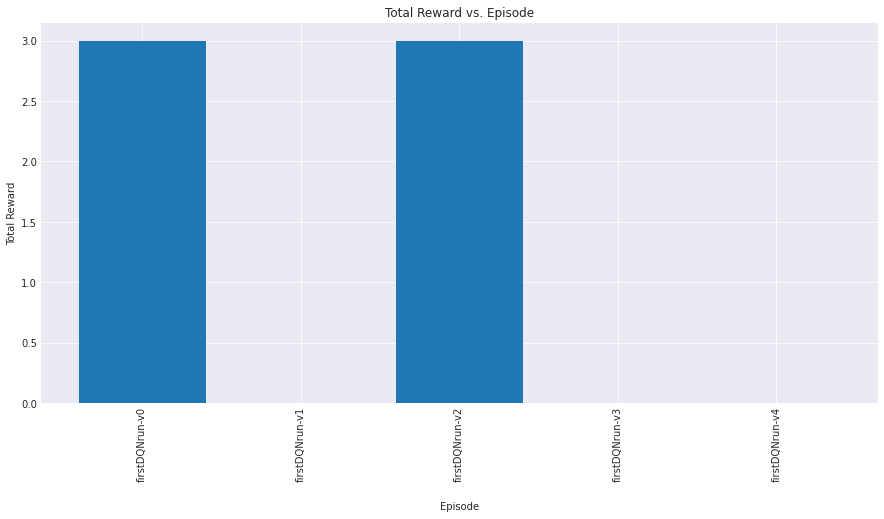

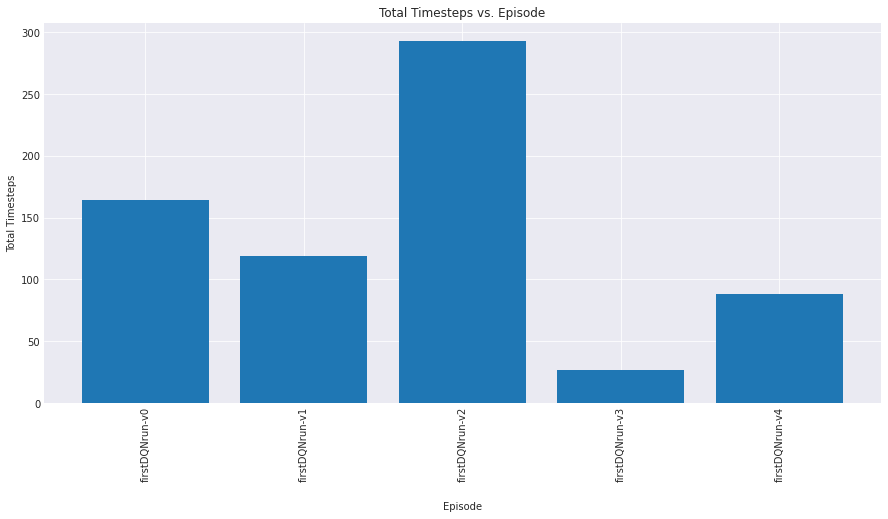

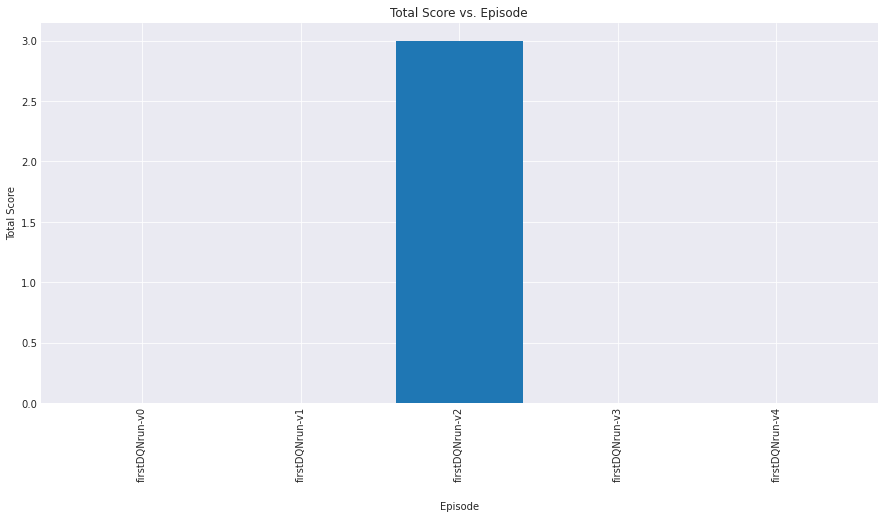

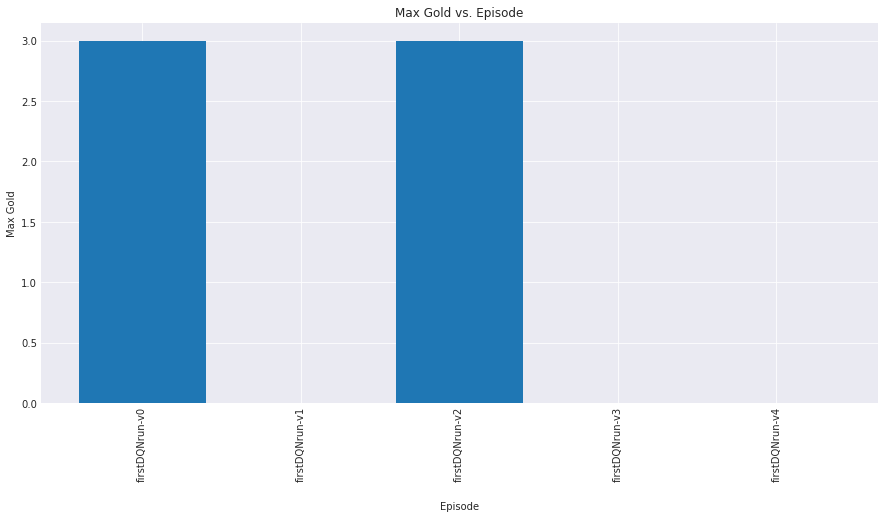

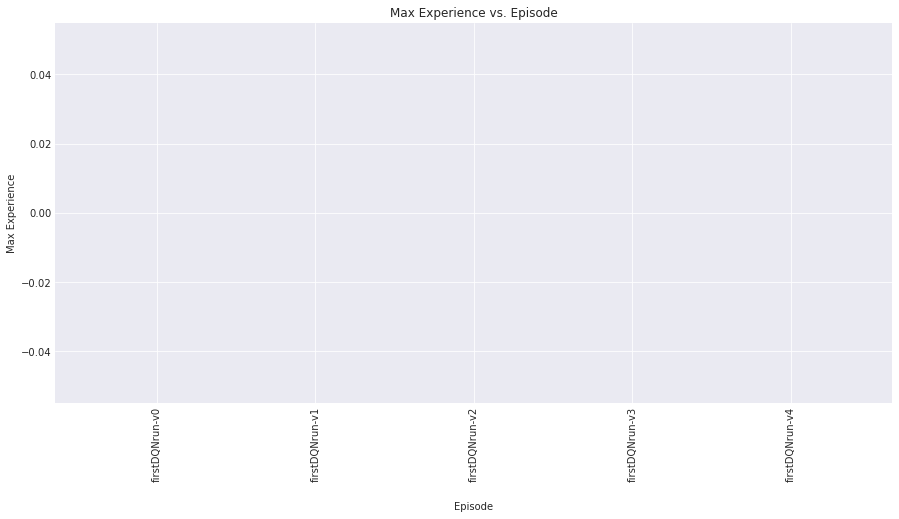

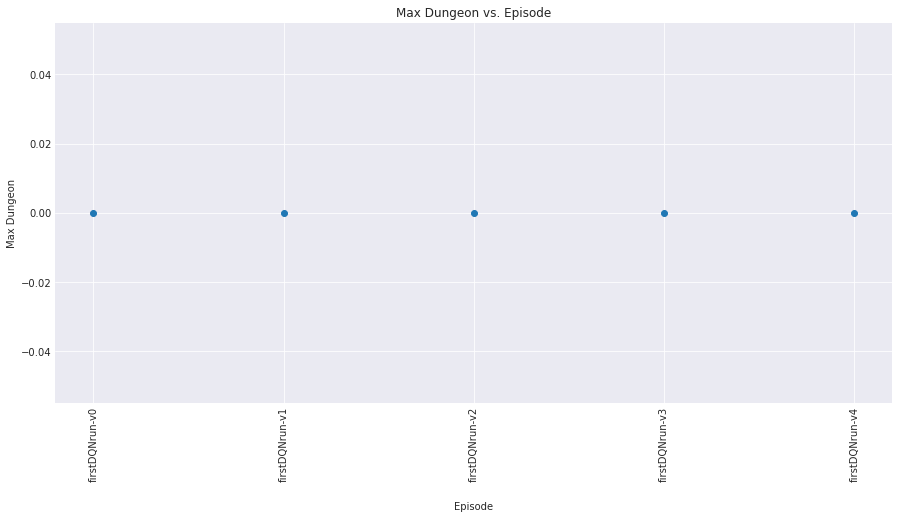

In [25]:
%%time
num_episodes = 5
global_steps = 0
for i_episode in range(num_episodes):
    print('Episode Number: ' + str(i_episode))
    # Initialize the environment and state
    obs = env.start(f'firstDQNrun-v{i_episode}')
    state = concat_state(obs)
    for t in count():
        # Select and perform an action
        action = select_action(state)
        global_steps += 1
        if global_steps == 10000:
            break
        obs, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        
        # Keep track of current state and previous states 
        last_state = state
        state = concat_state(obs)

        # Store the transition in memory
        memory.push(last_state, action, state, reward)

        # Perform one step of the optimization (on the policy network)
        optimize_model(t)
        if done:
            print(t+1)
            episode_durations.append(t + 1)
            break
    if global_steps == 10000:
        break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    env.finish()
print('Complete')
# no env close
env.write_report()

In [ ]:
env.write_report()

# Save the models
## Continue to train it later, or to load it up when you are testing. 

In [ ]:
torch.save(policy_net, 'policy-custom-reward')
torch.save(target_net, 'target-custom-reward')

# Testing

In [ ]:
"""
Loads the data if there is need for it. 
Should only be ran if we trained without testing and vice versa. 
"""
policy_net = torch.load('joe-policy')
policy_net.eval()
target_net = torch.load('joe-target')
target_net.eval()

In [ ]:
"""
Testing code will go below here
"""

In [ ]:
torch.save()